In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as sp

from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import loguniform, uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from insurance_classifier.dataset import DataPreprocessor

2026-02-04 15:25:40.373 | INFO     | insurance_classifier.config:<module>:11 - PROJ_ROOT path is: /home/iury_unix/ml_projects/h_insurance_cs


# 0.0 Loading data

In [2]:
train = pd.read_csv('../data/processed/train.csv')
test = pd.read_csv('../data/processed/test.csv')

X = train.drop(['response'], axis=1)
y = train['response'].copy()

X_test = test.drop(['id'], axis=1)

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

## 0.1 Helper Functions

In [4]:
def check_imbalance(df: pd.DataFrame)-> pd.DataFrame: 
    total = df.shape[0]
    no_count = df['response'].value_counts().iloc[0]
    yes_count = df['response'].value_counts().iloc[1]

    def highlight(val):
        return 'background-color: red; color: white; font-weight: bold;' if val < 20 else ''

    no_percentage = (no_count/total) * 100
    yes_percentage = 100 - no_percentage

    df_dist = pd.DataFrame({'no_count': no_count,
                            'yes_count': yes_count,
                            'no_percentage': no_percentage,
                            'yes_percentage': yes_percentage
                }, index=[0]).style.map(highlight, subset=['no_percentage','yes_percentage'])

    return df_dist 

def precision_at_k(y_true, y_proba, *, k):
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else: 
        pos_proba = y_proba
    idx = np.argsort(pos_proba)[::-1][:k]   
    
    return np.mean(y_true.iloc[idx])

def recall_at_k(y_true, y_proba, *, k):
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else: 
        pos_proba = y_proba
    idx = np.argsort(pos_proba)[::-1][:k]  

    return np.sum(y_true.iloc[idx]) / np.sum(y_true) if np.sum(y_true) > 0 else 0

def f_score_at_k(y_true, y_proba, *, k):   
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else: 
        pos_proba = y_proba
    idx = np.argsort(pos_proba)[::-1][:k] 

    precision = np.mean(y_true.iloc[idx])
    recall = np.sum(y_true.iloc[idx]) / np.sum(y_true)

    return  2 * ((precision * recall)/(precision + recall)) if (precision + recall) > 0 else 0

# Define @k scorers
precision_at_k_scorer = make_scorer(precision_at_k, response_method='predict_proba', k=20000)
recall_at_k_scorer = make_scorer(recall_at_k, response_method='predict_proba', k=20000)
f1_at_k_scorer = make_scorer(f_score_at_k, response_method='predict_proba', k=20000)


# 1.0 Baseline Models

## 1.1. Linear models (default params + single trainning)

### 1.1.1 Loss function = hinge (Linear SVM)

In [33]:
# Model initialization
sgd_lin = SGDClassifier(loss='hinge')

# Predict probabilities
clf = CalibratedClassifierCV(sgd_lin)

# Train
clf.fit(X_train, y_train)

# Predict
y_hat_lin = clf.predict_proba(X_val)


### 1.1.2 Loss function = log-loss (Logistic Regression)

In [34]:
# Model initialization
sgd_log = SGDClassifier(loss='log_loss')

# Train
sgd_log.fit(X_train, y_train)

# Predict
y_hat_log = sgd_log.predict_proba(X_val)

### 1.1.3 Baseline Performance

In [35]:
# Linear SVM
precision_lin = precision_at_k(y_true=y_val, y_proba=y_hat_lin, k=20000)
recall_lin = recall_at_k(y_true=y_val, y_proba=y_hat_lin, k=20000)

# Log-loss
precision_log = precision_at_k(y_true=y_val, y_proba=y_hat_log, k=20000)
recall_log = recall_at_k(y_true=y_val, y_proba=y_hat_log, k=20000)

# Dataframe
results = pd.DataFrame({'Model': ['Linear SVM', 'logistic regression'],
                        '@k': [20000, 20000],
                        'Precision@k': [precision_lin, precision_log],
                        'Recall@k': [recall_lin, recall_log]})
results

,Model,@k,Precision@k,Recall@k
0,Linear SVM,20000,0.30280,0.652586
1,logistic regression,20000,0.31235,0.673168


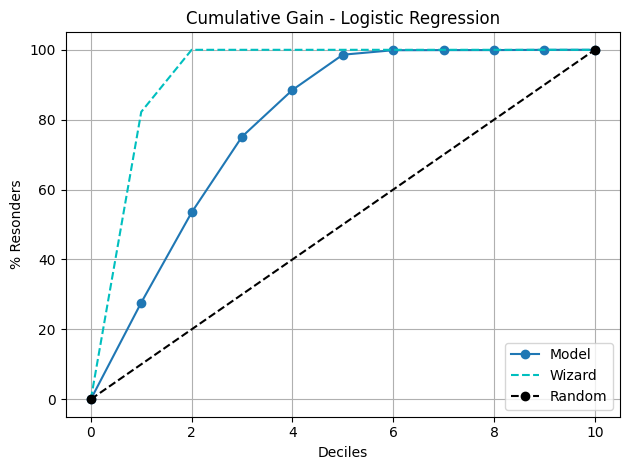

In [ ]:
sp.kds.plot_cumulative_gain(y_val, y_hat_log[:,1], title='Cumulative Gain - Logistic Regression');

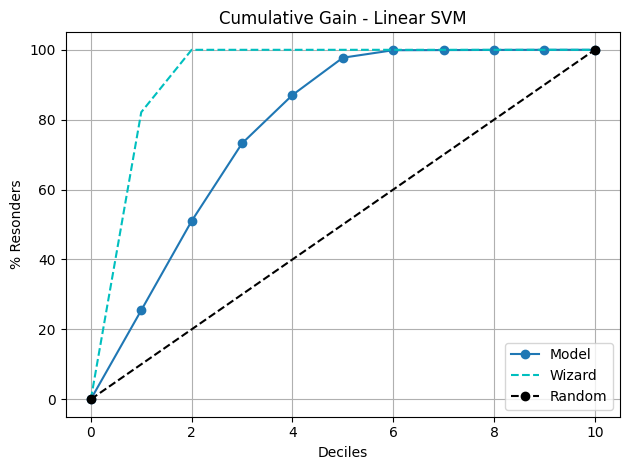

In [36]:
sp.kds.plot_cumulative_gain(y_val, y_hat_lin[:,1], title='Cumulative Gain - Linear SVM');

## 1.2 Non-linear Models (default params + single trainning)

### 2.1. K Neighbors Classifier

In [ ]:
# model initialization
knn = KNeighborsClassifier(n_neighbors=5)

# Train
knn.fit(X, y)

# Predict
knn_proba = knn.predict_proba(X_test)

### 2.2 Baseline Performance

In [ ]:
# KNN
precision_knn = precision_at_k(y_true=y, y_proba=knn_proba, k=20000)
recall_knn = recall_at_k(y_true=y, y_proba=knn_proba, k=20000)

# Dataframe
results_knn = pd.DataFrame({'Model': ['KNN'],
                        '@k': 20000,
                        'Precision@k': precision_knn,
                        'Recall@k': recall_knn})
results_knn

,Model,@k,Precision@k,Recall@k
0,KNN,20000,0.28305,0.610745


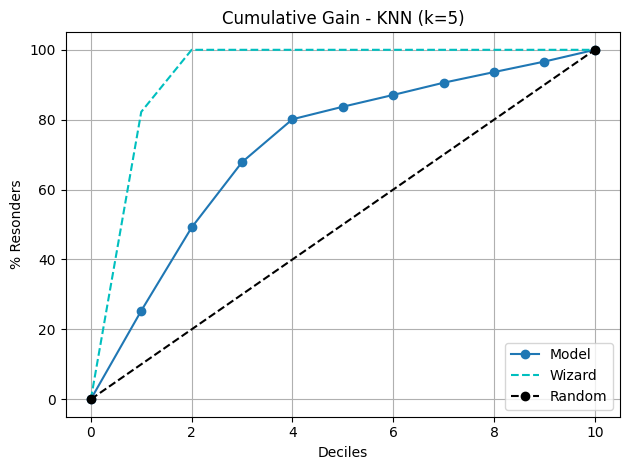

In [ ]:
sp.kds.plot_cumulative_gain(y, knn_proba[:,1], title='Cumulative Gain - KNN (k=5)');

# 3.0 Cross validation

## 3.1 SGD Classifier: Linear SVM  

In [69]:
sgd_lin = SGDClassifier(loss='hinge')

# Converting prediction to probabilities
lim_svm = CalibratedClassifierCV(sgd_lin)

# CV fitting
linear_svm_results = cross_validate(lim_svm, X, y, cv=5, scoring={'recall': recall_at_k_scorer, 'precision': precision_at_k_scorer, 'f1': f1_at_k_scorer})

In [72]:
# Performance results
linear_svm_df = pd.DataFrame(linear_svm_results)
linear_svm_df.rename(columns={'test_recall': 'recall@k', 'test_precision': 'precision@k', 'fit_time': 'fit_time', 'test_f1': 'f1-score@k'}, inplace=True)
linear_svm_df.drop(columns='score_time', inplace=True)
linear_svm_df = linear_svm_df[['precision@k', 'recall@k', 'f1-score@k', 'fit_time']]
linear_svm_df.sort_values(by='precision@k', ascending=False)

,precision@k,recall@k,f1-score@k,fit_time
2,0.31510,0.674588,0.429555,2.869240
1,0.31445,0.673196,0.428669,2.535746
4,0.30950,0.662599,0.421921,2.634191
3,0.30775,0.658852,0.419535,2.732694
0,0.30545,0.653928,0.416400,2.671189


## 3.2 SGD Classifier: Logistic regression 

In [73]:
sgd_log = SGDClassifier(loss='log_loss')

# CV fitting
log_loss = cross_validate(sgd_log, X, y, cv=5, scoring={'recall': recall_at_k_scorer, 'precision': precision_at_k_scorer, 'f1': f1_at_k_scorer})

In [74]:
# Performance results
log_loss_df = pd.DataFrame(log_loss)
log_loss_df.rename(columns={'test_recall': 'recall@k', 'test_precision': 'precision@k', 'fit_time': 'fit_time', 'test_f1': 'f1-score@k'}, inplace=True)
log_loss_df.drop(columns='score_time', inplace=True)
log_loss_df = log_loss_df[['precision@k', 'recall@k', 'f1-score@k', 'fit_time']]
log_loss_df.sort_values(by='precision@k', ascending=False)

,precision@k,recall@k,f1-score@k,fit_time
1,0.31765,0.680047,0.433031,0.510980
0,0.31735,0.679405,0.432622,0.541387
2,0.31680,0.678227,0.431872,0.549575
3,0.31570,0.675872,0.430373,0.506819
4,0.31440,0.673089,0.428601,0.505565


## 3.3 K-Neighbors Classifier 

In [75]:
knn = KNeighborsClassifier(n_neighbors=5)

# CV fitting
knn_results = cross_validate(knn, X, y, cv=5, scoring={'recall': recall_at_k_scorer, 'precision': precision_at_k_scorer, 'f1': f1_at_k_scorer})

In [76]:
# Performance results
knn_df = pd.DataFrame(knn_results)
knn_df.rename(columns={'test_recall': 'recall@k', 'test_precision': 'precision@k', 'fit_time': 'fit_time', 'test_f1': 'f1-score@k'}, inplace=True)
knn_df.drop(columns='score_time', inplace=True)
knn_df = knn_df[['precision@k', 'recall@k', 'f1-score@k', 'fit_time']]
knn_df.sort_values(by='precision@k', ascending=False)

,precision@k,recall@k,f1-score@k,fit_time
3,0.28515,0.610469,0.388726,0.697864
1,0.28220,0.604153,0.384705,0.607963
2,0.28135,0.602334,0.383546,25.569967
4,0.27935,0.598052,0.380819,0.612954
0,0.27745,0.593984,0.378229,0.729111


# 4.0 Fine Tuning

The model choosed to be tuned is the SGD with the loss function log_loss. Non linear models seens to perform poorly comparated to the linear models. 

In [4]:
sgd_log_loss = SGDClassifier(loss='log_loss',
                             max_iter=2000,
                             n_jobs=-1)

In [5]:
params = {
    'alpha': loguniform(1e-6, 1e-3),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': uniform(0.03,0.90),
    'class_weight': [None, 'balanced'] 
        }

search = RandomizedSearchCV(
        estimator=sgd_log_loss,
        param_distributions=params,
        n_iter=40,
        scoring=precision_at_k_scorer,
        cv=5,
        verbose=2
        )

In [ ]:
search.fit(X,y)

In [7]:
best_model = search.best_estimator_
best_score = search.best_score_
best_params = search.best_params_

In [43]:
best_sgd = SGDClassifier(loss='log_loss',
                         max_iter=2000,
                         n_jobs=-1,
                         alpha=5.973237672087022e-05,
                         class_weight= None,
                         l1_ratio=0.6612807183227329,
                         penalty='elasticnet')

In [48]:
best_sgd.fit(X_train,y_train)
y_hat_log = best_sgd.predict_proba(X_val)

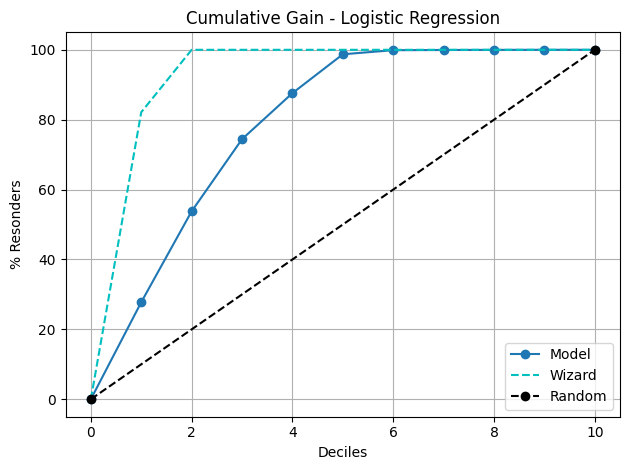

In [49]:
sp.kds.plot_cumulative_gain(y_val, y_hat_log[:,1], title='Cumulative Gain - Logistic Regression');

As we can see, the tuning doesn't make too much for the model. And it's highly possible that the low performance its caused by a strong imbalance dataset.

## 4.1 Revisiting performance metrics after resampling 

We already notice in the data wrangling process that the dataset is highly imbalanced. To adress this, we can use a resampling method. In this project we choose to use a over-sampling method. This method creates additional samples generated artificially in the dataset. The artificial samples are not generated randomly so the resampling has low bias. 

In [16]:
# Before resampling
check_imbalance(train)

,no_count,yes_count,no_percentage,yes_percentage
0,334399,46710,87.743664,12.256336


In [ ]:
sm = SMOTE()
X_res, y_res = sm.fit_resample(X, y)

# Merging X and y after resample to check imbalance
df_res = pd.concat([X_res, y_res], axis=1)  

In [23]:
df_res.shape

(668798, 14)

In [ ]:
# After resampling
check_imbalance(df_res)

,no_count,yes_count,no_percentage,yes_percentage
0,334399,334399,50.000000,50.000000


In [59]:
# Verify if the resampling affects the performance
log_loss_res = cross_validate(sgd_log_loss, X=X_res, y=y_res, cv=5, scoring={'recall': recall_at_k_scorer, 'precision': precision_at_k_scorer, 'f1': f1_at_k_scorer})

# Performance results
log_loss_df = pd.DataFrame(log_loss_res)
log_loss_df.rename(columns={'test_recall': 'recall@k', 'test_precision': 'precision@k', 'fit_time': 'fit_time', 'test_f1': 'f1-score@k'}, inplace=True)
log_loss_df.drop(columns='score_time', inplace=True)
log_loss_df = log_loss_df[['precision@k', 'recall@k', 'f1-score@k', 'fit_time']]
log_loss_df.sort_values(by='precision@k', ascending=False)

,precision@k,recall@k,f1-score@k,fit_time
1,0.79665,0.238233,0.366782,0.986085
0,0.79285,0.237096,0.365032,1.029753
3,0.79075,0.236468,0.364065,0.932016
2,0.78810,0.235676,0.362845,0.942791
4,0.78700,0.235350,0.362343,0.962174


After the SMOTE resampling, we can see clearly that the precision (target metric) had a great improvement.

In [52]:
X_res_train, X_res_val, y_res_train, y_res_val = train_test_split(X_res, y_res, test_size=0.2)

In [54]:
best_sgd.fit(X_res_train, y_res_train)
y_hat_res = best_sgd.predict_proba(X_res_val)

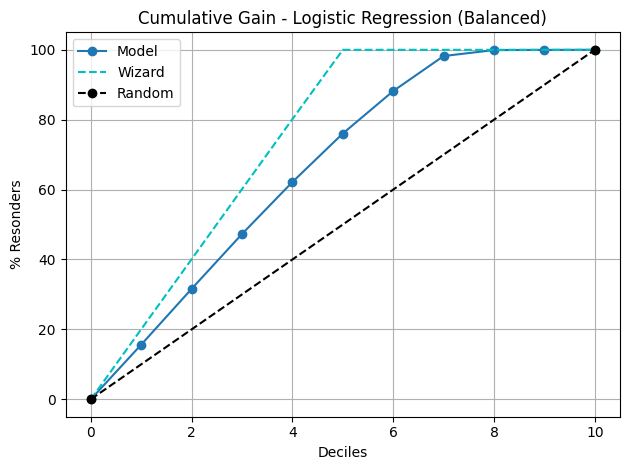

In [55]:
sp.kds.plot_cumulative_gain(y_res_val, y_hat_res[:,1], title='Cumulative Gain - Logistic Regression (Balanced)');

We can revisit the other models, just to be sure if any of they can get better performance.

In [60]:
sgd_lin = SGDClassifier(loss='hinge')

# Converting prediction to probabilities
lim_svm = CalibratedClassifierCV(sgd_lin)

# CV fitting
linear_svm_res = cross_validate(lim_svm, X_res, y_res, cv=5, scoring={'recall': recall_at_k_scorer, 'precision': precision_at_k_scorer, 'f1': f1_at_k_scorer})

# Performance results
linear_svm_df = pd.DataFrame(linear_svm_res)
linear_svm_df.rename(columns={'test_recall': 'recall@k', 'test_precision': 'precision@k', 'fit_time': 'fit_time', 'test_f1': 'f1-score@k'}, inplace=True)
linear_svm_df.drop(columns='score_time', inplace=True)
linear_svm_df = linear_svm_df[['precision@k', 'recall@k', 'f1-score@k', 'fit_time']]
linear_svm_df.sort_values(by='precision@k', ascending=False)

,precision@k,recall@k,f1-score@k,fit_time
1,0.78885,0.235900,0.363191,4.626057
3,0.78380,0.234390,0.360866,4.644454
0,0.78075,0.233478,0.359461,4.763336
2,0.77950,0.233104,0.358886,4.991987
4,0.77920,0.233018,0.358752,4.402200


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

# CV fitting
knn_res = cross_validate(knn, X_res, y_res, cv=5, scoring={'recall': recall_at_k_scorer, 'precision': precision_at_k_scorer, 'f1': f1_at_k_scorer})

# Performance results
knn_df = pd.DataFrame(knn_res)
knn_df.rename(columns={'test_recall': 'recall@k', 'test_precision': 'precision@k', 'fit_time': 'fit_time', 'test_f1': 'f1-score@k'}, inplace=True)
knn_df.drop(columns='score_time', inplace=True)
knn_df = knn_df[['precision@k', 'recall@k', 'f1-score@k', 'fit_time']]
knn_df.sort_values(by='precision@k', ascending=False)